In [2]:
from pathlib import Path
from torch.utils.data import Dataset
from monai.transforms import Compose, Transform, LoadImage, EnsureChannelFirst, Lambda, RepeatChannel, Resize, SpatialPad, ScaleIntensity, NormalizeIntensity
from monai.data import Dataset
import pandas as pd
import shutil
import random
import sys
import torch
import cv2

In [ ]:
def clean_data():
    csv_path = Path("../data/raw/paths_to_delete.csv")
    source_dir = Path("../data/raw/unzipped_raw_data")
    cleaned_dir = Path("../data/interim/cleaned_data")

    # --- Abort if already cleaned ---
    if cleaned_dir.exists():
        print(f"[INFO] {cleaned_dir} already exists.")
        return

    # --- Copy raw data ---
    print("Copying raw/unzipped_raw_data → data/interim/cleaned_data ...")
    shutil.copytree(source_dir, cleaned_dir)

    # --- Load paths to delete ---
    df = pd.read_csv(csv_path)

    deleted = 0
    

    # --- Delete files from copied data only ---
    deleted = 0
    for p in df["path"]:
      
      fp = Path(p.replace("../data/raw/unzipped_raw_data", "data/interim/cleaned_data"))
      if fp.exists():
          fp.unlink()
          deleted += 1

    print(f"Deleted {deleted} files from interim/cleaned_data.")
    
    return clean_data
    

In [11]:
clean_data() 

Copying raw/unzipped_raw_data → data/interim/cleaned_data ...
../data/interim/cleaned_data/test/normal/normal-491.jpg
../data/interim/cleaned_data/train/tuberculosis/tuberculosis-5903.jpg
../data/interim/cleaned_data/test/normal/normal-696.jpg
../data/interim/cleaned_data/train/pneumonia/pneumonia-3824.jpg
../data/interim/cleaned_data/test/normal/normal-131.jpg
../data/interim/cleaned_data/train/pneumonia/pneumonia-1315.jpg
../data/interim/cleaned_data/test/normal/normal-328.jpg
../data/interim/cleaned_data/train/tuberculosis/tuberculosis-4562.jpg
../data/interim/cleaned_data/test/normal/normal-715.jpg
../data/interim/cleaned_data/test/tuberculosis/tuberculosis-854.jpg
../data/interim/cleaned_data/test/normal/normal-129.jpg
../data/interim/cleaned_data/train/tuberculosis/tuberculosis-2784.jpg
../data/interim/cleaned_data/test/normal/normal-884.jpg
../data/interim/cleaned_data/train/pneumonia/pneumonia-4721.jpg
../data/interim/cleaned_data/test/normal/normal-439.jpg
../data/interim/clea

<function __main__.clean_data()>

In [5]:
def data_load(data_dir, inspect=True, n_samples=3):
    """
    Create a MONAI Dataset, ensure channels come first, and optionally inspect sample properties.

    Parameters
    ----------
    data_dir : str or Path
        Root directory containing image files.
    inspect : bool
        Whether to print sample dataset information.
    n_samples : int
        Number of samples to inspect. samples are chosen randomly.

    Returns
    -------
    dataset : monai.data.Dataset
        Lazy-loading MONAI dataset.    
    """
    data_dir = Path(data_dir)
    image_paths = list(data_dir.rglob("*.jpg"))

    transforms = Compose([
        LoadImage(image_only=True),
        EnsureChannelFirst(),
    ])

    dataset = Dataset(
        data=image_paths,
        transform=transforms
    )

    # 🔍 Lightweight inspection
    if inspect and len(dataset) > 0:
        print(f"Dataset size: {len(dataset)} images")

        sample_indices = random.sample(
            range(len(dataset)),
            min(n_samples, len(dataset))
        )

        for idx in sample_indices:
            img = dataset[idx]
            print(
                f"Sample {idx}: "
                f"shape={tuple(img.shape)}, "
                f"dtype={img.dtype}, "
                f"min={float(img.min()):.2f}, "
                f"max={float(img.max()):.2f}"
            )

    return dataset

Dataset size: 14373 images
Sample 3695: shape=(3, 1024, 1024), dtype=torch.float32, min=0.00, max=255.00
Sample 14165: shape=(3, 1160, 816), dtype=torch.float32, min=0.00, max=255.00
Sample 5993: shape=(3, 256, 246), dtype=torch.float32, min=0.00, max=247.00
Sample 3942: shape=(3, 1024, 1024), dtype=torch.float32, min=0.00, max=255.00
Sample 3897: shape=(3, 1024, 1024), dtype=torch.float32, min=0.00, max=255.00


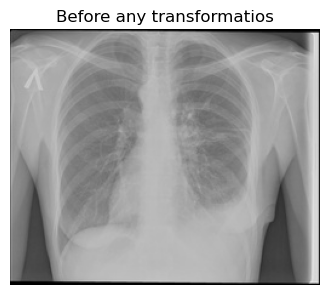

torch.Size([3, 256, 211])

In [6]:
# test 
test_data=data_load(data_dir='../data/interim/cleaned_data', inspect=True, n_samples=5)

import matplotlib.pyplot as plt
import numpy as np

img0_hwc = test_data[13589].permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(4,4))
plt.imshow(np.rot90(img0_hwc.astype("uint8"),k=3))
plt.axis("off")
plt.title("Before any transformatios")
plt.show()

test_data[13589].shape


In [7]:
class GCLAHE(Transform):
    """
    
    Create a Global-CLAHE transformation for image enhancement more suited for medical images.
    improves local contrast while preserving anatomical detail in medical images

    """
    
    def __init__(self, tile_grid_size=(8, 8), max_clip_limit=3.0):
        self.tile_grid_size = tile_grid_size
        self.max_clip_limit = max_clip_limit

    def __call__(self, img_tensor):
        #  (C, H, W) tensor to (H, W, C) numpy for ease of channel processing now. Will reverse it back later
        img_np = img_tensor.detach().cpu().numpy()
        
        processed_channels = []
        # Process each of the 3 channels individually
        for c in range(img_np.shape[0]):
            # 1. Scale to uint8 for OpenCV
            channel = (img_np[c] * 255).astype(np.uint8)
            
            # 2. Global Reference (GEI)
            gei = cv2.equalizeHist(channel)
            
            # 3. Local Enhancement (CLAHE)
            clahe = cv2.createCLAHE(clipLimit=self.max_clip_limit, tileGridSize=self.tile_grid_size)
            lei = clahe.apply(channel)
            
            # 4. G-CLAHE Blending: Maintain global brightness consistency
            # 50/50 blend is common to prevent local artifacts
            g_clahe_channel = cv2.addWeighted(lei, 0.5, gei, 0.5, 0)
            
            processed_channels.append(g_clahe_channel.astype(np.float32) / 255.0)
            
        # back to (3, H, W)
        return torch.from_numpy(np.stack(processed_channels))

def transform(dataset):
    """
    Return a new transformed Dataset
     a- convert to grayscale by averaging channels since some images have incononsistent channels
     b- repeat channels to have 3 channels again.
     c- resize to 224x224
     d- pad to ensure 224x224
     e- scale intensity to [0,1]
     f- apply G-CLAHE Transform class
     g- normalize intensity with ImageNet stats

    Parameters
    ----------
    dataset : monai.data.Dataset
        Existing dataset (paths will be reused).

    Returns
    -------
    dataset_transformed : monai.data.Dataset
        New dataset after applying the transformations.
    """
    image_paths = dataset.data  
    
    to_gray = Lambda(lambda x: x.mean(dim=0, keepdim=True))

    transforms = Compose([
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        to_gray,
        RepeatChannel(3),
        Resize((224, 224), mode='bilinear'),
        SpatialPad(spatial_size=(224, 224), method="symmetric"),
        ScaleIntensity(),               # [0,255] → [0,1]
        GCLAHE(tile_grid_size=(8, 8), max_clip_limit=3.0),
        NormalizeIntensity(
        subtrahend =[0.485, 0.456, 0.406],
        divisor=[0.229, 0.224, 0.225],
        channel_wise=True,
        ),
        
    ])

    dataset_transformed = Dataset(
        data=image_paths,
        transform=transforms
    )

    return dataset_transformed

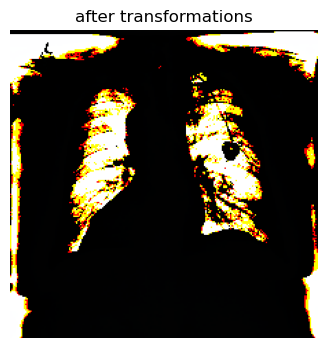

metatensor([[[ 2.2318,  1.9235, -0.4397,  ..., -1.8610, -1.8610, -1.8610],
         [ 2.2318,  1.9064, -0.7993,  ..., -1.8610, -1.8610, -1.8610],
         [ 2.2147,  1.8550, -0.7479,  ..., -1.8610, -1.8610, -1.8610],
         ...,
         [ 2.0263,  1.7865,  1.6153,  ..., -1.7754, -1.7412, -1.7754],
         [ 2.0434,  1.8208,  1.6153,  ..., -0.8849, -0.8507, -0.8164],
         [ 2.0948,  1.8722,  1.6838,  ...,  0.2111,  0.2796,  0.3138]],

        [[ 2.4111,  2.0959, -0.3200,  ..., -1.7731, -1.7731, -1.7731],
         [ 2.4111,  2.0784, -0.6877,  ..., -1.7731, -1.7731, -1.7731],
         [ 2.3936,  2.0259, -0.6352,  ..., -1.7731, -1.7731, -1.7731],
         ...,
         [ 2.2010,  1.9559,  1.7808,  ..., -1.6856, -1.6506, -1.6856],
         [ 2.2185,  1.9909,  1.7808,  ..., -0.7752, -0.7402, -0.7052],
         [ 2.2710,  2.0434,  1.8508,  ...,  0.3452,  0.4153,  0.4503]],

        [[ 2.6226,  2.3088, -0.0964,  ..., -1.5430, -1.5430, -1.5430],
         [ 2.6226,  2.2914, -0.4624,  ...

In [8]:
test_data2 = transform(test_data)

import matplotlib.pyplot as plt
import numpy as np

img0_hwc = test_data2[99].permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(4,4))
plt.imshow(np.rot90(img0_hwc.astype("uint8"),k=3))
plt.axis("off")
plt.title("after transformations")
plt.show()

test_data2[0]


In [9]:
class add_split_class(Dataset):
    
    """
    A custom Dataset wrapper that adds 'class' and 'split' metadata based on file paths without modifying image tensors or transforms.

    """
    
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.paths = base_dataset.data  # original image paths

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image = self.base_dataset[idx]  # tensor, unchanged
        path = Path(self.paths[idx])

        return {
            "image": image,
            "path": str(path),
            "class": path.parent.name,        # normal / pneumonia / tuberculosis
            "split": path.parent.parent.name,      # train / val / test
        }


In [10]:
# test

x= add_split_class(test_data2)
len(x)

x[0].keys()
x[0]["image"]

metatensor([[[ 2.2318,  1.9235, -0.4397,  ..., -1.8610, -1.8610, -1.8610],
         [ 2.2318,  1.9064, -0.7993,  ..., -1.8610, -1.8610, -1.8610],
         [ 2.2147,  1.8550, -0.7479,  ..., -1.8610, -1.8610, -1.8610],
         ...,
         [ 2.0263,  1.7865,  1.6153,  ..., -1.7754, -1.7412, -1.7754],
         [ 2.0434,  1.8208,  1.6153,  ..., -0.8849, -0.8507, -0.8164],
         [ 2.0948,  1.8722,  1.6838,  ...,  0.2111,  0.2796,  0.3138]],

        [[ 2.4111,  2.0959, -0.3200,  ..., -1.7731, -1.7731, -1.7731],
         [ 2.4111,  2.0784, -0.6877,  ..., -1.7731, -1.7731, -1.7731],
         [ 2.3936,  2.0259, -0.6352,  ..., -1.7731, -1.7731, -1.7731],
         ...,
         [ 2.2010,  1.9559,  1.7808,  ..., -1.6856, -1.6506, -1.6856],
         [ 2.2185,  1.9909,  1.7808,  ..., -0.7752, -0.7402, -0.7052],
         [ 2.2710,  2.0434,  1.8508,  ...,  0.3452,  0.4153,  0.4503]],

        [[ 2.6226,  2.3088, -0.0964,  ..., -1.5430, -1.5430, -1.5430],
         [ 2.6226,  2.2914, -0.4624,  ...

In [13]:
# testing indexing and subsetting

train_indices = [
    i for i, p in enumerate(x.paths)
    if Path(p).parent.parent.name == "train"
]

train_indices 

from torch.utils.data import Subset

train_data = Subset(x, train_indices)
len(train_data)

11534

In [14]:
def get_split(dataset, split_name):
    """
    Return a subset of the dataset corresponding to the given split.
    """
    indices = [
        i for i, p in enumerate(dataset.paths)
        if Path(p).parent.parent.name == split_name
    ]
    return Subset(dataset, indices)

In [21]:
train_data = get_split(x, "train")
len(train_data)
train_data[0]["class"]

'normal'

In [1]:
# import os, sys
# print("CWD:", os.getcwd())
# print("sys.path[0]:", sys.path[0])

#/usr/bin/python /home/ramy/Ramy/chestxray/chestxray_module/process.py

import sys
print(sys.executable)


/home/ramy/miniforge3/envs/medical_imaging/bin/python
